In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_band(path, nodata_to_nan=True):
    """
    Loads a Sentinel-2 band as float32.
    Optionally converts NoData (0) values to NaN.
    """
    with rasterio.open(path) as src:
        band = src.read(1).astype(np.float32)
    return band


def percentile_normalize(band, p_low=2, p_high=98):
    """
    Percentile-based normalization for visualization.
    """
    p2, p98 = np.nanpercentile(band, (p_low, p_high))
    band_clipped = np.clip(band, p2, p98)
    band_norm = (band_clipped - p2) / (p98 - p2)
    return band_norm

B04 stats:
  min: 0.0
  max: 65535.0
  dtype: float32


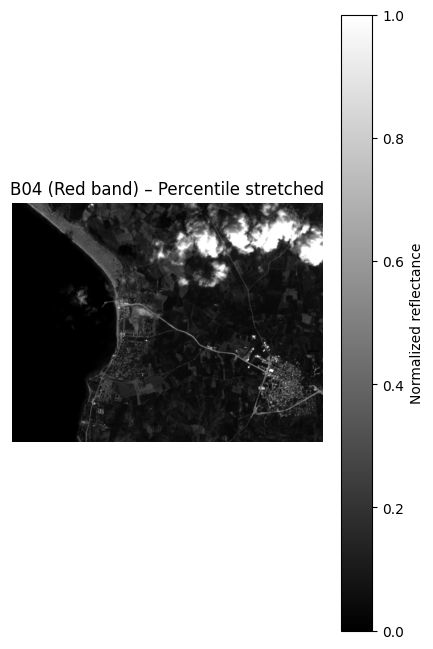

In [ ]:
# File path
path_b02 = "2025-11-12-00_00_2025-11-12-23_59_Sentinel-2_L2A_B02_(Raw).tiff"
path_b03 = "2025-11-12-00_00_2025-11-12-23_59_Sentinel-2_L2A_B03_(Raw).tiff"
path_b04 = "2025-11-12-00_00_2025-11-12-23_59_Sentinel-2_L2A_B04_(Raw).tiff"

# Load the bands
band_b02 = load_band(path_b02)
band_b03 = load_band(path_b03)
band_b04 = load_band(path_b04)

# Debug info
print("B04 stats:")
print("  min:", np.nanmin(band_b04))
print("  max:", np.nanmax(band_b04))
print("  dtype:", band_b04.dtype)


# Normalization for visualization
band_b04_vis = percentile_normalize(band_b04)

# Image testing
plt.figure(figsize=(5, 8))
plt.imshow(band_b04_vis, cmap="gray")
plt.colorbar(label="Normalized reflectance")
plt.title("B04 (Red band) – Percentile stretched")
plt.axis("off")
plt.show()

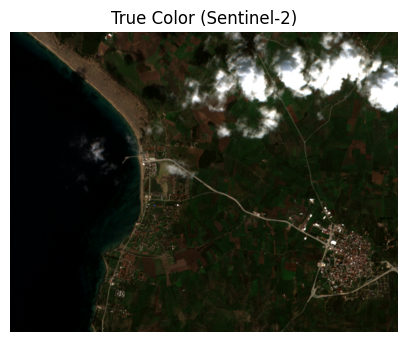

In [ ]:
# # Percentile-based normalization for RGB visualization (True Color)
B = percentile_normalize(band_b02)  # Blue
G = percentile_normalize(band_b03)  # Green
R = percentile_normalize(band_b04)  # Red

# RGB stack
rgb = np.dstack((R, G, B))

plt.figure(figsize=(5, 8))
plt.imshow(rgb)
plt.title("True Color (Sentinel-2)")
plt.axis("off")
plt.show()

In [ ]:
# No normalization
b11 = load_band("2025-11-12-00_00_2025-11-12-23_59_Sentinel-2_L2A_B11_(Raw).tiff", nodata_to_nan=True)

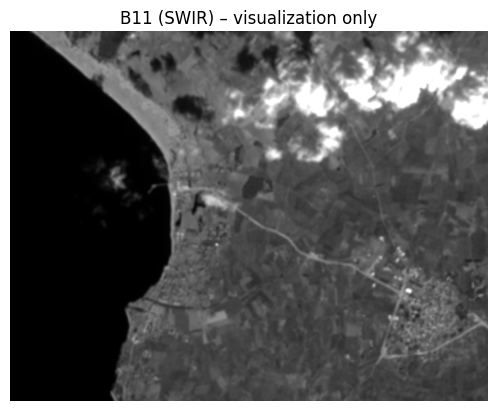

In [ ]:
b11_vis = percentile_normalize(b11)

plt.imshow(b11_vis, cmap="gray")
plt.title("B11 (SWIR) – visualization only")
plt.axis("off")
plt.show()


In [ ]:
path_b08 = "2025-11-12-00_00_2025-11-12-23_59_Sentinel-2_L2A_B08_(Raw).tiff"

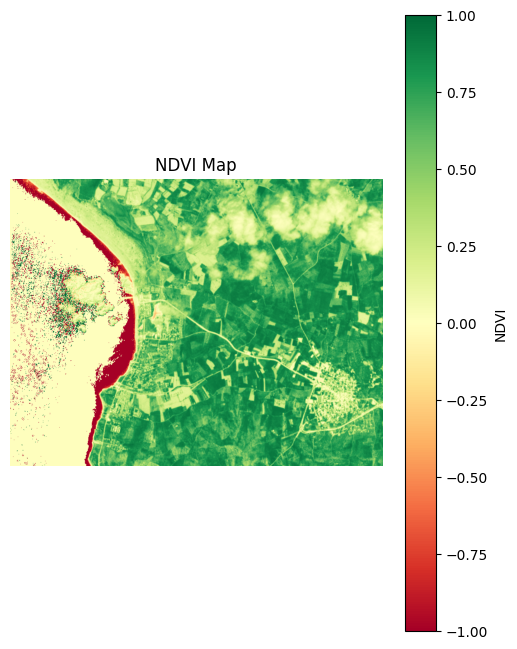

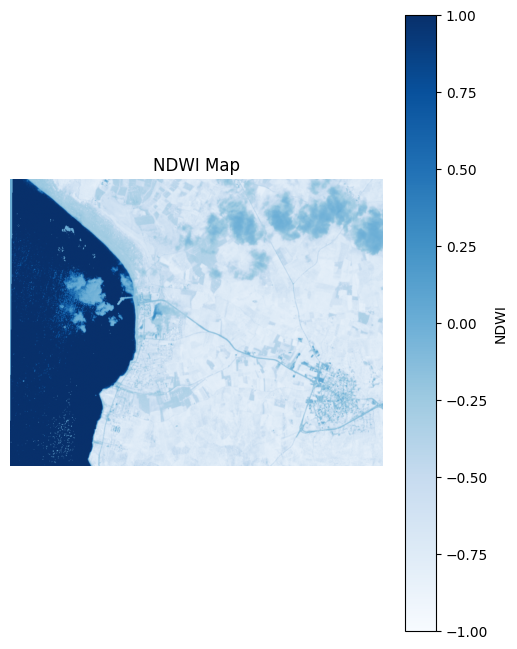

In [ ]:
b02 = load_band(path_b02)
b03 = load_band(path_b03)
b04 = load_band(path_b04)
b08 = load_band(path_b08)

# NDVI: (B08 - B04) / (B08 + B04)
ndvi = np.divide(
    (b08 - b04),
    (b08 + b04),
    out=np.zeros_like(b08),
    where=(b08 + b04) != 0
)

# NDWI: (B03 - B08) / (B03 + B08)
ndwi = np.divide(
    (b03 - b08),
    (b03 + b08),
    out=np.zeros_like(b03),
    where=(b03 + b08) != 0
)


plt.figure(figsize=(6, 8))
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar(label="NDVI")
plt.title("NDVI Map")
plt.axis("off")
plt.show()


plt.figure(figsize=(6, 8))
plt.imshow(ndwi, cmap="Blues")
plt.colorbar(label="NDWI")
plt.title("NDWI Map")
plt.axis("off")
plt.show()


In [ ]:
def compute_masks(b02, b03, b04, b08, b11, ndvi, ndwi):
    """
    Computes water, vegetation, urban and cloud masks
    using rule-based spectral thresholds.
    """
    brightness = (b02 + b03 + b04) / 3.0

    whiteness = 1.0 - (
        np.abs(b04 - b03) +
        np.abs(b04 - b02) +
        np.abs(b03 - b02)
    ) / (b04 + b03 + b02 + 1e-6)

    # Adaptive threshold for brightness
    br_thr = np.nanpercentile(brightness, 95)
    wh_thr = 0.65

    cloud_mask = (
        (brightness > br_thr) &
        (whiteness > wh_thr) &
        (ndvi < 0.2) &
        (ndwi < 0.1)
    )

    water_mask = (ndwi > 0.1) & (~cloud_mask)

    vegetation_mask = (ndvi > 0.3) & (~water_mask) & (~cloud_mask)

    urban_mask = (
        (~water_mask) &
        (~vegetation_mask) &
        (~cloud_mask) &
        (b11 > 2000)
    )

    return water_mask, vegetation_mask, urban_mask, cloud_mask

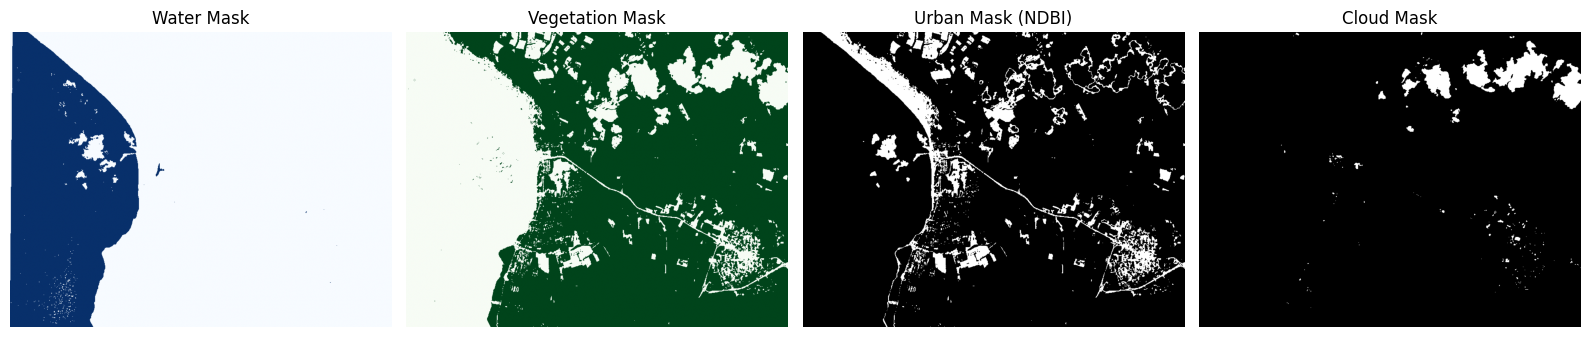

In [ ]:
# NDBI: (B11 - B08) / (B11 + B08)
ndbi = np.divide((b11 - b08), (b11 + b08), out=np.zeros_like(b11), where=(b11 + b08) != 0)

water_mask, vegetation_mask, urban_mask, cloud_mask = compute_masks(
    b02, b03, b04, b08, b11, ndvi, ndwi
)

# Visualization
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(water_mask, cmap="Blues")
plt.title("Water Mask")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(vegetation_mask, cmap="Greens")
plt.title("Vegetation Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(urban_mask, cmap="gray")
plt.title("Urban Mask (NDBI)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(cloud_mask, cmap="gray")
plt.title("Cloud Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import rasterio

def area_from_mask_m2(mask: np.ndarray, pixel_area_m2: float) -> dict:
    pixel_count = int(np.nansum(mask.astype(np.uint8)))
    area_m2 = pixel_count * pixel_area_m2
    return {
        "pixels": pixel_count,
        "area_m2": area_m2,
        "area_ha": area_m2 / 10_000.0,
        "area_km2": area_m2 / 1_000_000.0
    }

def compute_class_areas_m2(water_mask, vegetation_mask, urban_mask, cloud_mask, pixel_area_m2: float, valid_mask=None):
    water = water_mask.astype(bool)
    veg = vegetation_mask.astype(bool)
    urban = urban_mask.astype(bool)
    cloud = cloud_mask.astype(bool)

    if valid_mask is None:
        valid = np.ones_like(water, dtype=bool)
    else:
        valid = valid_mask.astype(bool)

    water = water & valid
    veg = veg & valid
    urban = urban & valid
    cloud = cloud & valid

    other = valid & (~water) & (~veg) & (~urban) & (~cloud)

    results = {
        "water": area_from_mask_m2(water, pixel_area_m2),
        "vegetation": area_from_mask_m2(veg, pixel_area_m2),
        "urban": area_from_mask_m2(urban, pixel_area_m2),
        "cloud": area_from_mask_m2(cloud, pixel_area_m2),
        "other": area_from_mask_m2(other, pixel_area_m2),
        "total_valid": area_from_mask_m2(valid, pixel_area_m2),
    }

    df = pd.DataFrame({
        k: {
            "pixels": v["pixels"],
            "area_m2": v["area_m2"],
            "area_ha": v["area_ha"],
            "area_km2": v["area_km2"],
        }
        for k, v in results.items()
    }).T

    return results, df

# Read pixel_area_m2 from the file.
with rasterio.open(path_b08) as src:
    pixel_area_m2 = abs(src.transform.a * src.transform.e)
    print("CRS:", src.crs)
    print("pixel_area_m2:", pixel_area_m2)

# valid_mask: Exclude NoData/empty fields
# If you set 0s to NaN in load_band, exclude the valid field via b08:
valid_mask = np.isfinite(b08)

results, df = compute_class_areas_m2(
    water_mask, vegetation_mask, urban_mask, cloud_mask,
    pixel_area_m2=pixel_area_m2,
    valid_mask=valid_mask
)

print(df)


CRS: EPSG:32635
pixel_area_m2: 58.17704639506919
               pixels       area_m2      area_ha   area_km2
water        140996.0  8.202731e+06   820.273083   8.202731
vegetation   349729.0  2.034620e+07  2034.620026  20.346200
urban         61779.0  3.594120e+06   359.411975   3.594120
cloud         18999.0  1.105306e+06   110.530570   1.105306
other          3451.0  2.007690e+05    20.076899   0.200769
total_valid  574954.0  3.344913e+07  3344.912553  33.449126
